# 07 Time Series forecast with RandomForestRegressor

Random Forest is an ensemble ML method (Bagging technique: Bootstrapping + Aggregating).  Multiple decision trees are trained and their predictions are combined (aggregating) and they provide more accurate predictions than any individual estimator. Bootstrapping requires training each base model in the ensemble on a randomly drawn subset of the training set. 

I read the data after the preliminary EDA performed as part of the project proposal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer

I read the training and the test set.

In [2]:
X_tr_valid = np.load('X_tr_imputed.npy')
y_tr_valid = np.load('y_tr.npy')

# X_valid = np.load('features_valid.npy')
# y_valid = np.load('labels_valid.npy')

X_test = np.load('X_te_imputed.npy')
y_test = np.load('y_te.npy')

In [3]:
df_tr = pd.read_pickle('training_dataset_df.csv')

I define the quantile transformation and the columns of the future matrix that it will be applied.

In [4]:
# qt_columns = ['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'PM10'] if pandas dataframe
qt_columns = [6,7,8,9,10,11,12,15,16] # column indexes
qt = QuantileTransformer(n_quantiles = 1000, random_state = 0)

I apply the Quantile transformation of n = 1000 quantiles to the target vector. The Quantile-transformed target vector is y_tr_qt.

In [5]:
y_tr_valid_qt = qt.fit_transform(y_tr_valid.reshape(-1, 1))[:,0]
y_tr_valid_qt.shape

(30704,)

In [6]:
y_test_qt = qt.fit_transform(y_test.reshape(-1, 1))[:,0]

In [7]:
y_tr_valid.shape

(30704,)

In [8]:
y_tr_valid.reshape(-1, 1).shape

(30704, 1)

I define the error functions (more on the metrics later)

In [9]:
# Mean Absolute error (MAE)
def MAE(y,y_pred):    
    return(np.mean(np.abs(y-y_pred)))

def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))


# Invert log-transformation and compute model error  -- not nneeded if quantile transformation used for target vector
def model_error(y,y_pred):
    # score = MAE(np.exp(y),np.exp(y_pred)) # Invert log-transformation and compute MAE
    score = MAE(y, y_pred) # invert QuantileTransformation
    # y_test does not need to be transformed
    return score

def RSS(y,y_pred):
    # score = MAE(np.exp(y),np.exp(y_pred)) # Invert log-transformation and compute MAE 
    # score = RSS(y_test, qt.inverse_transform(y_pred)) # invert QuantileTransformation
    score = np.sum(np.square(y - y_pred))# invert QuantileTransformation
    # y_test does not need to be transformed
    return score


def R2_score(y,y_pred, y_train):
    score = 1-(RSS(y, y_pred)/RSS(y,y_train.mean()))
    return score      

the data training/valid and test data have One-Hot-Encoding for all the categorical features. I define my pipeline for the rest of the preprocessing and the model-fitting with the kNRegressor. I will scale the data before using the KNRegressor as it is a distance-based estimator. Anyway it is a good practise to scale the features as the chances for the estimator to converge to a global minimum error (not a local one) are better with scaling. 

Bootstrapping requires training each base estimator (decision tree) in the ensemble on a randomly drawn subset of the training set. To obtain a deterministic behaviour during bootstrapping random_state has to be fixed.

In [10]:
rforest_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('preprocessor', ColumnTransformer([('quantile', qt, qt_columns)], remainder='passthrough')),
    ('rforest', RandomForestRegressor(random_state = 0, criterion = 'mae', n_jobs = -1,verbose = 4)) # Grid search not needed
])

In [11]:
rforest_pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'preprocessor': ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
          transformer_weights=None,
          transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
           output_distribution='uniform', random_state=0, subsample=100000), [6, 7, 8, 9, 10, 11, 12, 15, 16])]),
 'rforest': RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=0, verbose=4, warm_start=False)}

I define a grid for the hyperparameters I want to fine tune.

In [12]:
grid = { 
         'rforest__n_estimators' : [1, 50, 200, 300, 500]
       }

With time series data we have to preserve the chronological order of observations because of their temporal dependency (autocorrelation). We cannot shuffle the data so we can only learn from the past and predict the future, not the other way around. That means that the training set will always precede the validation set. If we choose one validation set we do not know if it is representative of what we would observe in the future. Therefore k-fold cross-validation comes into play to reduce the bias of an ML model estimation of the prediction error. Moreover the final score will be the average of scores obtained in each fold. This reduces overfitting and constitutes a more robust way of model evaluation. I will use the TimeSeriesSplit to split the time series training set in rolling k = 2 folds.

In [13]:
tscv = TimeSeriesSplit(n_splits = 4)

In [14]:
tscv.split(X_tr_valid)
for train_index, valid_index in tscv.split(X_tr_valid, y_tr_valid_qt):
    print(train_index, valid_index)

[   0    1    2 ... 6141 6142 6143] [ 6144  6145  6146 ... 12281 12282 12283]
[    0     1     2 ... 12281 12282 12283] [12284 12285 12286 ... 18421 18422 18423]
[    0     1     2 ... 18421 18422 18423] [18424 18425 18426 ... 24561 24562 24563]
[    0     1     2 ... 24561 24562 24563] [24564 24565 24566 ... 30701 30702 30703]


In [15]:
tscv.get_n_splits()

4

In [16]:
for train_index, valid_index in tscv.split(X_tr_valid, y_tr_valid_qt):
    X_train, X_valid = X_tr_valid[train_index], X_tr_valid[valid_index]
    y_train, y_valid = y_tr_valid[train_index], y_tr_valid[valid_index]

After generating the k-folds I will use the GridSearchCV to do the grid search for hyperparameter tuning.

In [17]:
y_tr_valid.shape

(30704,)

By default the metric used is the determination coefficient but I want to use the negative mean absolute error (NMAE) and therefore I sill set the scoring parameter respectively. The - sign is added in the end to allow for the schikit convention "higher" is better.

In [18]:
grid_cv = GridSearchCV(rforest_pipe, grid, cv = tscv, return_train_score = True, verbose = 1, n_jobs = -1, scoring = 'neg_mean_absolute_error')

In [19]:
grid_cv.fit(X_tr_valid, y_tr_valid_qt)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 212.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500building tree 2 of 500building tree 3 of 500building tree 4 of 500building tree 5 of 500building tree 6 of 500building tree 7 of 500building tree 8 of 500







building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.9min


building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 16.1min


building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building t

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 38.2min


building tree 213 of 500
building tree 214 of 500
building tree 215 of 500
building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500
building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500
building tree 240 of 500
building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 244 of 500
building tree 245 of 500
building tree 246 of 500
building tree 247 of 500
building tree 248 of 500
building tree 249 of 500
building tree 250 of 500
building tree 251 of 500
building tree 252 of 500


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 68.8min


building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 91.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...mators='warn', n_jobs=-1,
           oob_score=False, random_state=0, verbose=4, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rforest__n_estimators': [1, 50, 200, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [53]:
grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...stimators=300, n_jobs=-1,
           oob_score=False, random_state=0, verbose=4, warm_start=False))])

In [20]:
grid_cv.cv_results_

{'mean_fit_time': array([ 147.29891723, 1242.49253833, 4279.5302555 , 5539.14956856,
        6362.72062498]),
 'std_fit_time': array([ 117.9235899 ,  942.82260718, 2922.91126032, 3269.11101597,
        2959.03391122]),
 'mean_score_time': array([0.02934271, 0.1331864 , 0.13188344, 9.86976093, 0.36565375]),
 'std_score_time': array([2.95717860e-03, 4.39105261e-03, 1.89958228e-03, 1.66937062e+01,
        9.23594826e-02]),
 'param_rforest__n_estimators': masked_array(data=[1, 50, 200, 300, 500],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'rforest__n_estimators': 1},
  {'rforest__n_estimators': 50},
  {'rforest__n_estimators': 200},
  {'rforest__n_estimators': 300},
  {'rforest__n_estimators': 500}],
 'split0_test_score': array([-0.0676259 , -0.04509086, -0.04441983, -0.04436474, -0.04424396]),
 'split1_test_score': array([-0.05620665, -0.03712769, -0.03655299, -0.03657921, -0.0364829 ]),
 'split2_test_score': ar

In [21]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_rforest__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'mean_train_score', 'std_train_score'])

In [22]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_rforest__n_estimators']
cv_results[cols].sort_values(by = 'mean_test_score', ascending = False).head()

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_rforest__n_estimators
4,-0.040347,0.002993,-0.014840,0.001210,500
3,-0.040454,0.003007,-0.014886,0.001204,300
2,-0.040483,0.003048,-0.014943,0.001203,200
1,-0.041138,0.003105,-0.015403,0.001270,50
0,-0.061296,0.004200,-0.022787,0.002107,1


I will now turn the results to MAE.

In [23]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_test_score', 'param_rforest__n_estimators']
cv_results['mean_test_score'] = np.abs(cv_results['mean_test_score'])
cv_results['mean_train_score'] = np.abs(cv_results['mean_train_score'])
cv_results[cols].sort_values(by = 'mean_test_score', ascending = True).head(10)

,mean_test_score,std_test_score,mean_train_score,std_test_score,param_rforest__n_estimators
4,0.040347,0.002993,0.014840,0.002993,500
3,0.040454,0.003007,0.014886,0.003007,300
2,0.040483,0.003048,0.014943,0.003048,200
1,0.041138,0.003105,0.015403,0.003105,50
0,0.061296,0.004200,0.022787,0.004200,1


In [24]:
cv_results.to_pickle('RandomForest_cv2.csv')
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rforest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,147.298917,117.923590,0.029343,0.002957,1,{'rforest__n_estimators': 1},-0.067626,-0.056207,-0.062055,-0.059295,0.061296,0.004200,5,-0.026090,-0.023097,-0.021316,-0.020643,0.022787,0.002107
1,1242.492538,942.822607,0.133186,0.004391,50,{'rforest__n_estimators': 50},-0.045091,-0.037128,-0.043019,-0.039313,0.041138,0.003105,4,-0.017381,-0.015650,-0.014254,-0.014329,0.015403,0.001270
2,4279.530255,2922.911260,0.131883,0.001900,200,{'rforest__n_estimators': 200},-0.044420,-0.036553,-0.042242,-0.038717,0.040483,0.003048,3,-0.016823,-0.015166,-0.013888,-0.013895,0.014943,0.001203
3,5539.149569,3269.111016,9.869761,16.693706,300,{'rforest__n_estimators': 300},-0.044365,-0.036579,-0.042147,-0.038726,0.040454,0.003007,2,-0.016769,-0.015102,-0.013825,-0.013846,0.014886,0.001204


In [25]:
cv_results = pd.read_pickle('RandomForest_cv2.csv')
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rforest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,147.298917,117.923590,0.029343,0.002957,1,{'rforest__n_estimators': 1},-0.067626,-0.056207,-0.062055,-0.059295,0.061296,0.004200,5,-0.026090,-0.023097,-0.021316,-0.020643,0.022787,0.002107
1,1242.492538,942.822607,0.133186,0.004391,50,{'rforest__n_estimators': 50},-0.045091,-0.037128,-0.043019,-0.039313,0.041138,0.003105,4,-0.017381,-0.015650,-0.014254,-0.014329,0.015403,0.001270
2,4279.530255,2922.911260,0.131883,0.001900,200,{'rforest__n_estimators': 200},-0.044420,-0.036553,-0.042242,-0.038717,0.040483,0.003048,3,-0.016823,-0.015166,-0.013888,-0.013895,0.014943,0.001203
3,5539.149569,3269.111016,9.869761,16.693706,300,{'rforest__n_estimators': 300},-0.044365,-0.036579,-0.042147,-0.038726,0.040454,0.003007,2,-0.016769,-0.015102,-0.013825,-0.013846,0.014886,0.001204


In [26]:
mean_train = cv_results['mean_train_score']
mean_test = cv_results['mean_test_score']
std_train = cv_results['std_train_score']
std_test = cv_results['std_test_score']
n_estimators = cv_results['param_rforest__n_estimators']
                          
std_plus = np.array((mean_test + std_test), dtype = float)
std_minus = np.array((mean_test - std_test), dtype = float)

In [27]:
std_plus

array([0.06549532, 0.04424319, 0.04353069, 0.04346087, 0.04333989])

In [30]:
std_minus

array([0.05709608, 0.0380323 , 0.03743497, 0.03744746, 0.0373546 ])

In [31]:
index = mean_test.idxmin()
best_n = cv_results['param_rforest__n_estimators'][index]
best_n

500

In [32]:
grid_cv.best_estimator_.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('preprocessor',
  ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
           transformer_weights=None,
           transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
            output_distribution='uniform', random_state=0, subsample=100000), [6, 7, 8, 9, 10, 11, 12, 15, 16])])),
 ('rforest',
  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
             oob_score=False, random_state=0, verbose=4, warm_start=False))]

In [33]:
grid_cv.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...stimators=500, n_jobs=-1,
           oob_score=False, random_state=0, verbose=4, warm_start=False))])>

In [34]:
scores = cv_results[['mean_test_score',  'std_test_score', 'mean_train_score', 'std_train_score', 'param_rforest__n_estimators']]

In [35]:
scores.columns = ['MAE_test','std_test_score', 'MAE_train', 'std_train_score',  'n_estimators']
scores.head()

,MAE_test,std_test_score,MAE_train,std_train_score,n_estimators
0,0.061296,0.004200,0.022787,0.002107,1
1,0.041138,0.003105,0.015403,0.001270,50
2,0.040483,0.003048,0.014943,0.001203,200
3,0.040454,0.003007,0.014886,0.001204,300
4,0.040347,0.002993,0.014840,0.001210,500


In [36]:
scores_te = scores[['MAE_test', 'n_estimators']]

In [37]:
#scores = np.array(scores).reshape(len(Cs), len(Gammas))

In [38]:
scores_te.head()

,MAE_test,n_estimators
0,0.061296,1
1,0.041138,50
2,0.040483,200
3,0.040454,300
4,0.040347,500


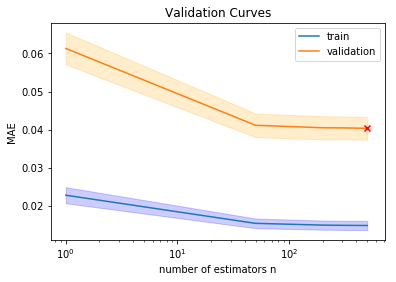

In [39]:
plt.semilogx(cv_results['param_rforest__n_estimators'], cv_results['mean_train_score'], label = 'train')
plt.semilogx(cv_results['param_rforest__n_estimators'], cv_results['mean_test_score'], label = 'validation')


# plt.fill_between(cv_results2['param_knnreg__n_neighbors'], mean_train - std_train, mean_train + std_train, alpha=0.2)
# plt.fill_between(cv_results2['param_knnreg__n_neighbors'], mean_test - std_test, std_plus, alpha=0.2)
# plt.fill_between(k, std_minus, std_plus, alpha=0.2)
# k has to transformed to float otherwise error is thrown therefore: np.array(k,dtype = float)
plt.fill_between(np.array(n_estimators, dtype = float), std_minus, std_plus, alpha=0.2, color = 'orange')
plt.fill_between(np.array(n_estimators, dtype = float), (mean_train - std_train), (mean_train + std_train), alpha=0.2, color = 'blue')
plt.scatter(best_n, cv_results['mean_test_score'].min(), marker='x', c='red', zorder=10)


plt.title('Validation Curves')
plt.xlabel('number of estimators n')
plt.ylabel('MAE')
plt.legend()
plt.show()

I observe that the optimum value of n_estimators is at the end of the grid search which would require to extend the grid search with higher values. Due to the fact that it is computentially expensive and the time increases exponentially I will go on with the current value.

### Making and evaluating predictions 

I will now use the estimator with the optimum setting of the hyperparameter n_estimators which is n_estimators = 100.

In [40]:
rforest_pipe_best = Pipeline([
    ('scaler', StandardScaler()), 
    ('preprocessor', ColumnTransformer([('quantile', qt, qt_columns)], remainder='passthrough')),
    ('rforest', RandomForestRegressor(random_state = 0, criterion = 'mae', n_estimators = best_n, n_jobs = -1)) # best_n according to grid search
])

or simply (having retrofit = True)

In [41]:
# predict
y_test_pred_qt = grid_cv.best_estimator_.predict(X_test)
# invert the quantile transformation
y_test_pred = qt.inverse_transform(y_test_pred_qt.reshape(-1, 1))[:,0]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 376 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


In [42]:
rforest_mae = MAE(y_test, y_test_pred)

I will evaluate the predictions calculating the scores (MAE and R2).

In [43]:
r2 = R2_score(y_test, y_test_pred, y_tr_valid)
r2

0.8631107852784861

In [44]:
results_rforest = {'model': ['RandomForest'], 'r2_score': r2, 'MAE': rforest_mae}
results_rforest = pd.DataFrame(results_rforest)
np.save('results_RandomForest', results_rforest)
results_rforest

,model,r2_score,MAE
0,RandomForest,0.863111,26.657944


In [45]:
y_test_df = pd.read_pickle('y_te.csv')
y_test_df = pd.DataFrame(y_test_df)
y_test_df['PM2.5 - prediction'] = y_test_pred
y_test_df.head()

,PM2.5,PM2.5 - prediction
Date and Time,,
2016-09-01 00:00:00,12.0,9.0
2016-09-01 01:00:00,17.0,10.0
2016-09-01 02:00:00,3.0,13.0
2016-09-01 03:00:00,8.0,8.0
2016-09-01 04:00:00,14.0,9.0


I save the predictions

In [46]:
y_test_df.to_pickle('RandomForestv2_predictions.csv')

### Ploting the predictions along with the real values

In [47]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [48]:
y_test_df = pd.read_pickle('y_te.csv')
y_test_df = pd.DataFrame(y_test_df)
y_test_df['PM2.5 - prediction'] = y_test_pred
y_test_df['Residuals'] = y_test - y_test_pred
y_test_df.head()

,PM2.5,PM2.5 - prediction,Residuals
Date and Time,,,
2016-09-01 00:00:00,12.0,9.0,3.0
2016-09-01 01:00:00,17.0,10.0,7.0
2016-09-01 02:00:00,3.0,13.0,-10.0
2016-09-01 03:00:00,8.0,8.0,0.0
2016-09-01 04:00:00,14.0,9.0,5.0


In [49]:
font_dict = {'fontname':'Arial', 'size':'16'}

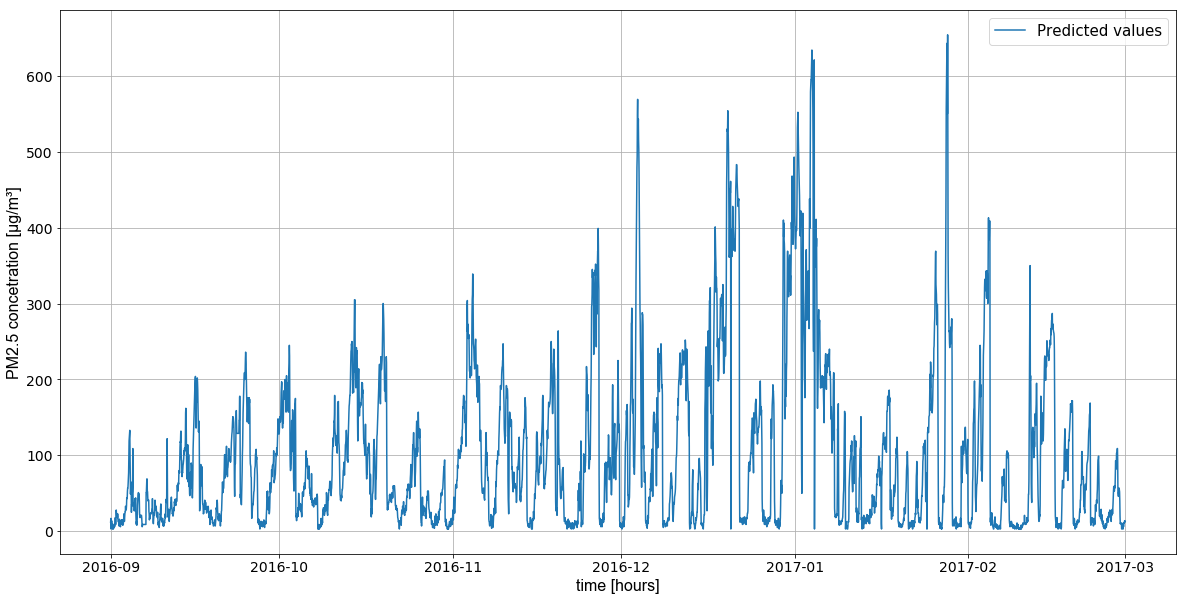

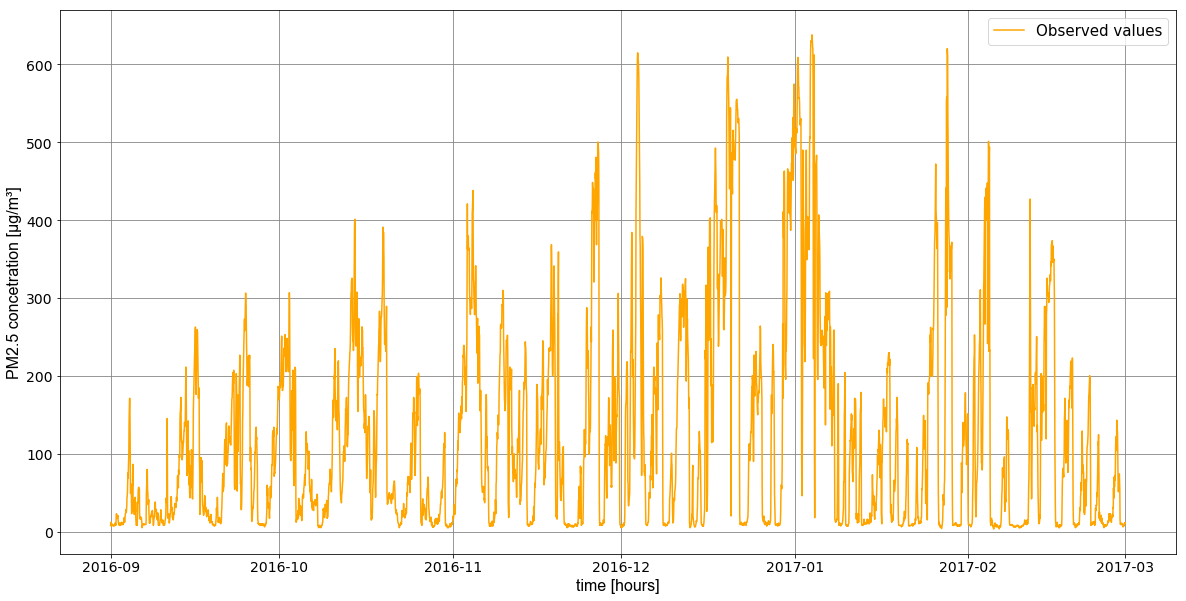

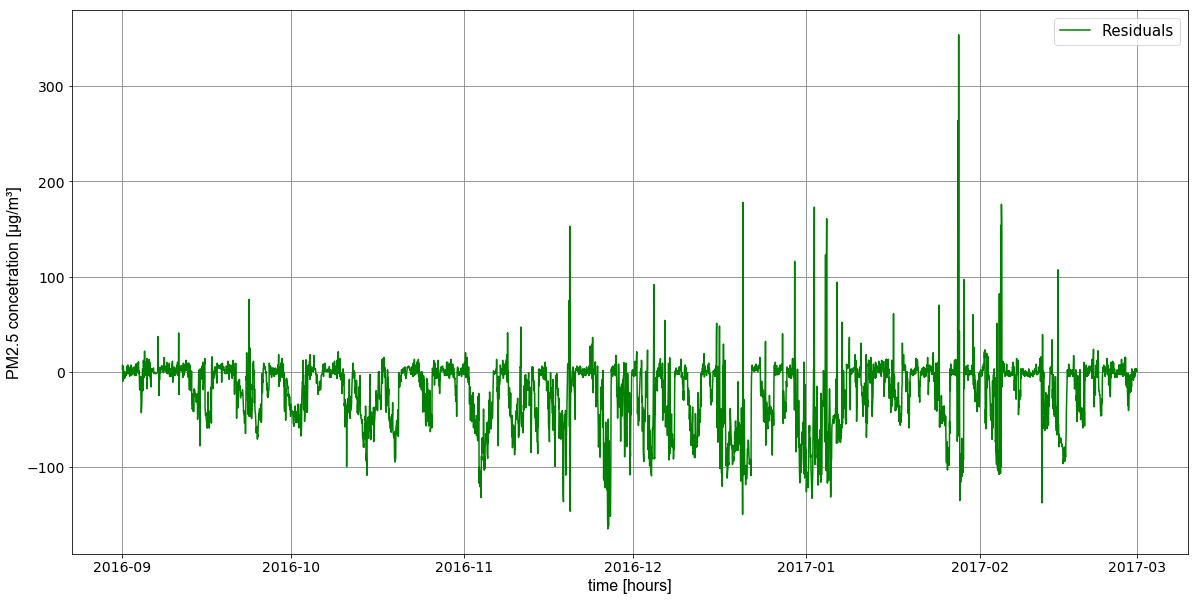

In [50]:
# plot Observations
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5'], label = 'Predicted values')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()
# plot Predictions
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5 - prediction'], color = 'orange', label = 'Observed values')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()
# plot Residuals
plt.figure(figsize = (20,10))
plt.plot(y_test_df['Residuals'], color = 'green', label = 'Residuals')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

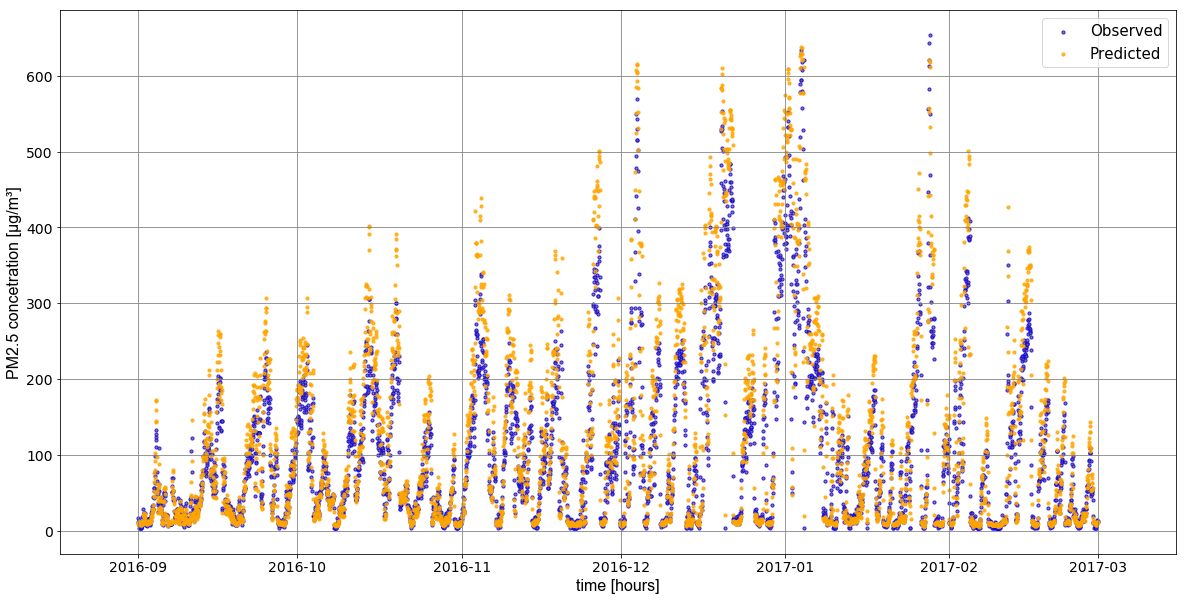

In [51]:
plt.figure(figsize = (20,10))
plt.scatter(y_test_df.index, y_test_df['PM2.5'], color = 'blue',  s=10, facecolors='C5', edgecolors='b', alpha = 0.8, label = 'Observed')
plt.scatter(y_test_df.index, y_test_df['PM2.5 - prediction'], color = 'orange', s=10, facecolors='orange', edgecolors='orange', alpha = 0.8, label = 'Predicted')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

for better readability I will plot the prediction for one month.

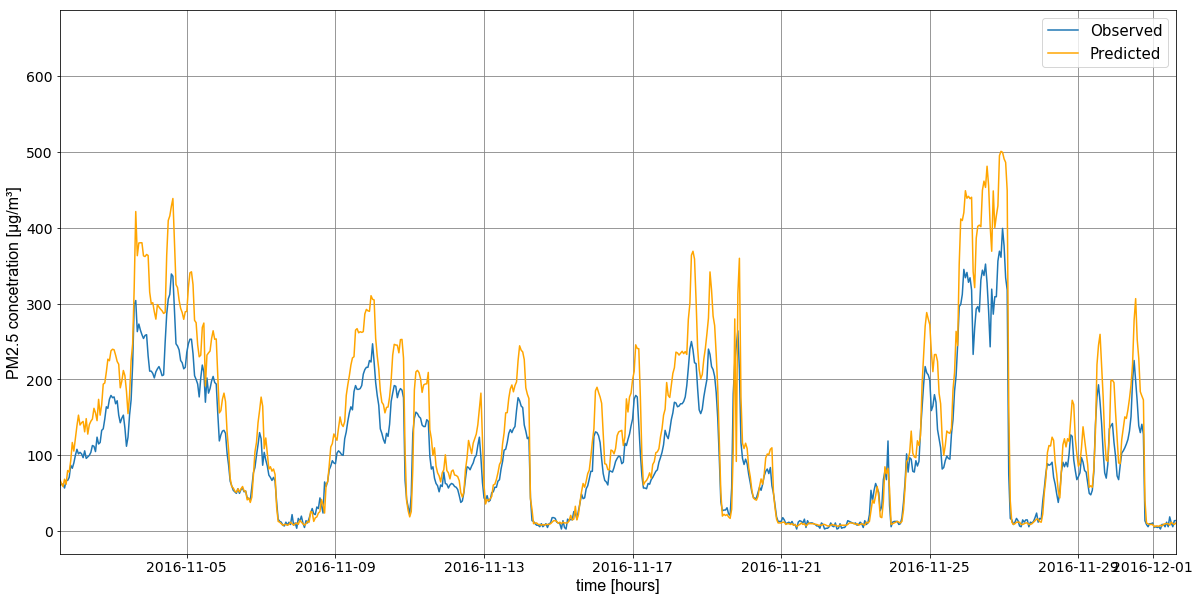

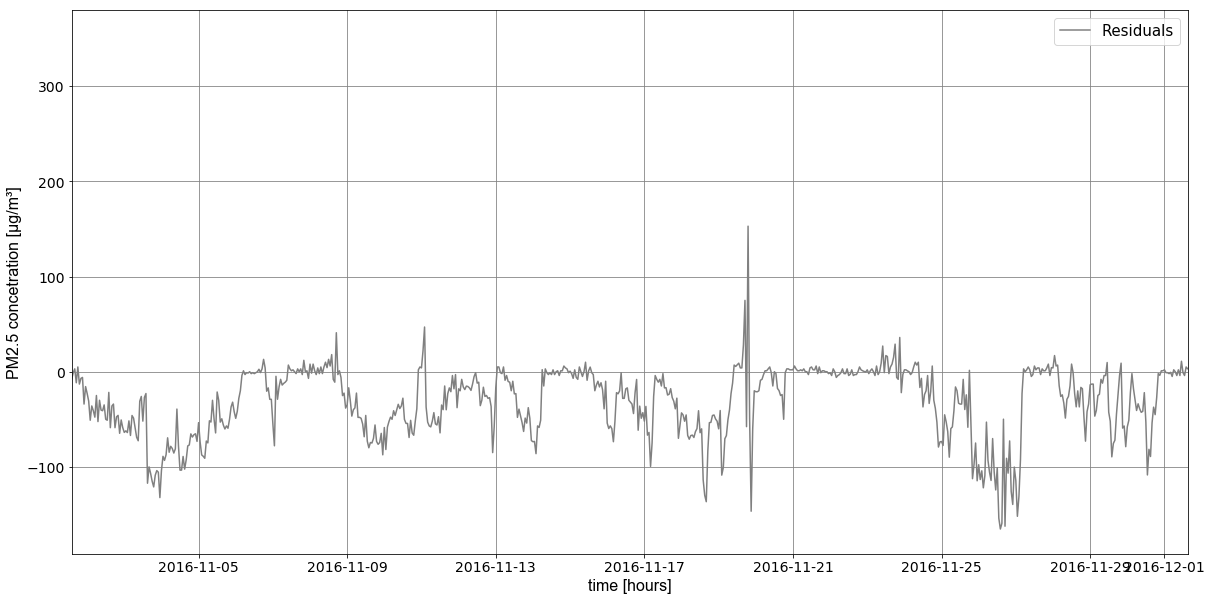

In [52]:
# plot Observations
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5'], label = 'Observed')

# plot Predictions
plt.plot(y_test_df['PM2.5 - prediction'], color = 'orange', label = 'Predicted')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

# plot Residuals
plt.figure(figsize = (20,10))
plt.plot(y_test_df['Residuals'], color = 'grey')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

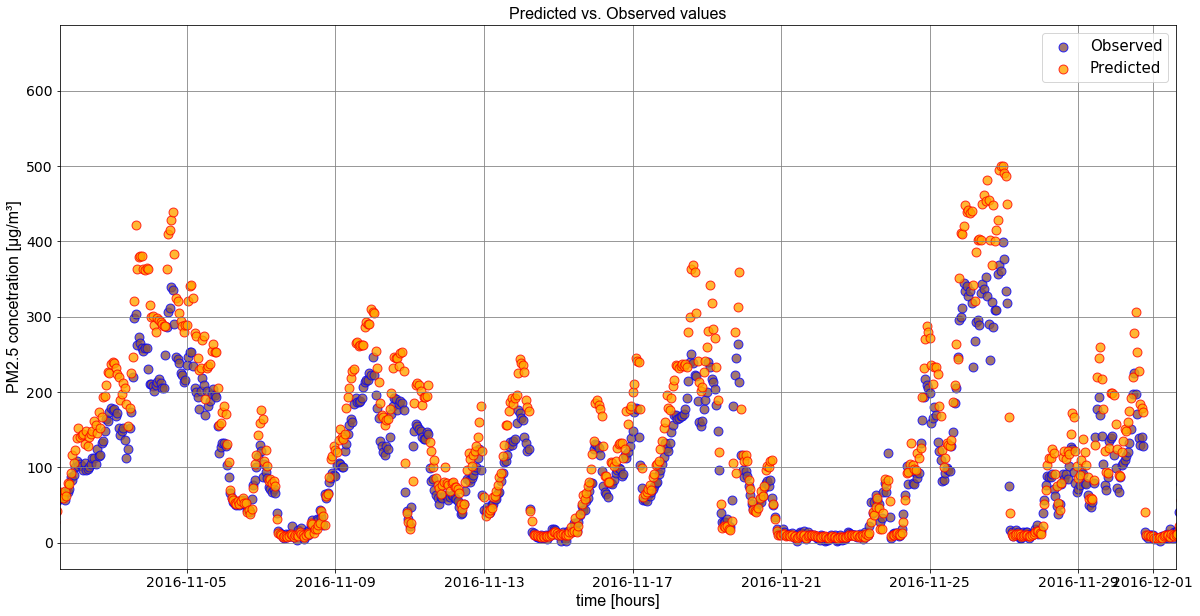

In [53]:
plt.figure(figsize = (20,10))
plt.scatter(y_test_df.index, y_test_df['PM2.5'], color = 'blue',  s=80, facecolors='C5', edgecolors='b', alpha = 0.8, label = 'Observed')
plt.scatter(y_test_df.index, y_test_df['PM2.5 - prediction'], color = 'orange', s=80, facecolors='orange', edgecolors='r', alpha = 0.8, label = 'Predicted')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.title('Predicted vs. Observed values', fontdict = font_dict)
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

In this case the RandomForest Regressor makes an overstimation. This can be also seen from the resudual.